# Question 3_c

Name = Maryam Karimi Jafari

Student ID = 99106617

# Setup

In [30]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os

import keras
from imutils import paths
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
from IPython.display import Image
from keras.utils import to_categorical
from keras import regularizers, layers


# Loading Data

creating a pandas dataframe from videos file path and their coresponding labels.

In [33]:
dataset_train_path = '/content/drive/MyDrive/SCR_HW3_Q4_LipReading/train'
dataset_test_path = '/content/drive/MyDrive/SCR_HW3_Q4_LipReading/test'

In [34]:
def create_dataframe_from_videos_name(folder_path):
    """
    Reads video file names from the given folder, extracts labels, and stores
    the file paths and labels in a pandas DataFrame.

    Args:
        folder_path (str): Path to the folder containing video files.

    Returns:
        pd.DataFrame: DataFrame with columns ['file_path', 'label'].
    """
    file_paths = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.mp4'):
            file_path = os.path.join(folder_path, filename)
            label = filename.split('w')[1].split('-')[0]
            file_paths.append(file_path)
            labels.append(label)

    data = {'file_path': file_paths, 'label': labels}
    df = pd.DataFrame(data)

    return df

In [35]:
train_df = create_dataframe_from_videos_name(dataset_train_path)
test_df = create_dataframe_from_videos_name(dataset_test_path)

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 160
Total videos for testing: 40


,file_path,label
115,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,5
149,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,4
143,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,1
30,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,4
72,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,5
148,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,4
25,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,3
155,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,5
112,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,4
0,/content/drive/MyDrive/SCR_HW3_Q4_LipReading/t...,1


# Define hyperparameters

dut to the lack of memory i had to reduce the image size, batch size and number of epochs for this approach, because the 3D CNN use the frames themslves, not their embedings after a feature extractor part.

In [62]:
IMG_SIZE = 80
BATCH_SIZE = 32
EPOCHS = 50

MAX_SEQ_LENGTH = 30
NUM_FEATURES = 2048

# Data preparation

function for loading a video and making the frames.

In [37]:
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames) / 255.0

printing the labels and converting them to one hot encoding.

In [38]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["label"])
)
print(label_processor.get_vocabulary())

['1', '2', '3', '4', '5']


In [39]:
classes = to_categorical([int(i) for i in np.unique(train_df["label"])])
print(classes)

[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


## actually loading the data

In [40]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["file_path"].values.tolist()
    labels = df["label"].values
    labels = to_categorical(keras.ops.convert_to_numpy(label_processor(labels[..., None])))

    #`frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = batch[None, j, :]

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data.shape}")
print(f"Frame features in test set: {test_data.shape}")

Frame features in train set: (160, 30, 80, 80, 3)
Frame features in test set: (40, 30, 80, 80, 3)


# building the model and training+evaluating

## training

In [63]:
def get_model(width=224, height=224, depth=30):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth, width, height, 3))

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2))(x)
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2))(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2))(x)


    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=5, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3D_CNN")
    return model


# Build model.
model = get_model(width=IMG_SIZE, height=IMG_SIZE, depth=MAX_SEQ_LENGTH)
model.summary()

Model: "3D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 30, 80, 80, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_24 (Conv3D)                   │ (None, 28, 78, 78, 32)      │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_16 (MaxPooling3D)      │ (None, 28, 39, 39, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_25 (Conv3D)                   │ (None, 26, 37, 37, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_17 (MaxPooling3D)      │ (None, 26, 18, 18, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_26 (Conv3D)                   │ (None, 24, 16, 16, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_27 (Conv3D)                   │ (None, 22, 14, 14, 128)     │         442,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_18 (MaxPooling3D)      │ (None, 22, 7, 7, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_28 (Conv3D)                   │ (None, 20, 5, 5, 128)       │         442,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_29 (Conv3D)                   │ (None, 18, 3, 3, 128)       │         442,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_19 (MaxPooling3D)      │ (None, 18, 1, 1, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,021,829 (19.16 MB)

 Trainable params: 5,021,829 (19.16 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Compile model.
sch = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                                  decay_steps=100000,
                                                  decay_rate=0.9)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=sch),
    metrics=["accuracy"],
    run_eagerly=True,
)

# Define callbacks.
filepath = "/content/drive/MyDrive/video_classifier_3D_CNN/HW3_3_c_11.keras"
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_accuracy', save_best_only=True, verbose=1
)

# Train the model, doing validation at the end of each epoch
history = model.fit(
    train_data,
    train_labels,
    validation_split = 0.2,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[checkpoint],
)


_, accuracy = model.evaluate(test_data, test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.2135 - loss: 1.6329
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /content/drive/MyDrive/video_classifier_3D_CNN/HW3_3_c_11.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 890ms/step - accuracy: 0.2146 - loss: 1.6327 - val_accuracy: 0.2500 - val_loss: 1.6056
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.2103 - loss: 1.6089
Epoch 2: val_accuracy improved from 0.25000 to 0.46875, saving model to /content/drive/MyDrive/video_classifier_3D_CNN/HW3_3_c_11.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step - accuracy: 0.2104 - loss: 1.6094 - val_accuracy: 0.4688 - val_loss: 1.5911
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.2201 - loss: 1.5999
Epoch 3: val_accuracy did not improve from 0.46875
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 645ms/step - accuracy: 0.2229 - loss: 1.5991 - val_accuracy: 0.1562 - val_loss: 1.5072
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.3184 - loss: 1.5349

result for evaluating => test accuracy = 82.5%

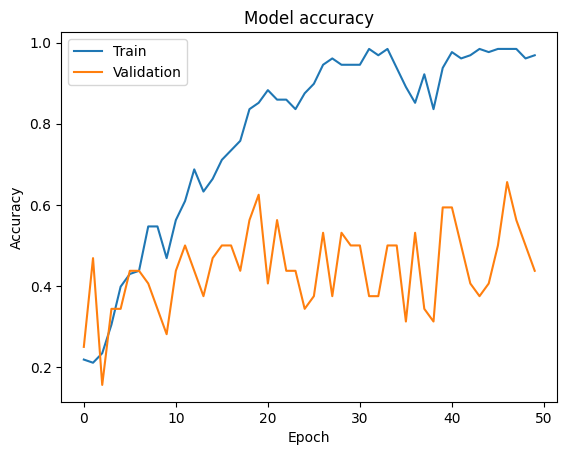

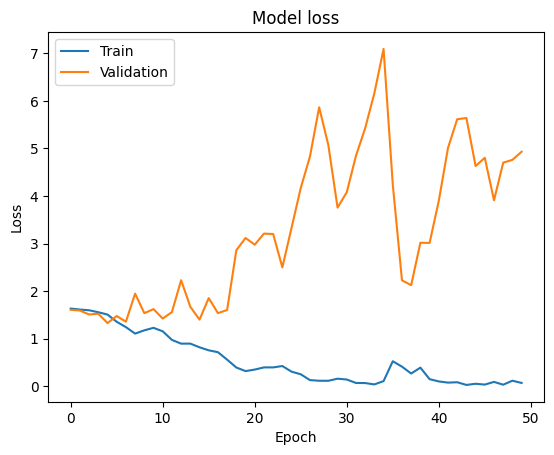

In [65]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## testing the result on a single random video

the result is 98.63% for class 1 which is right.

Test video path: /content/drive/MyDrive/SCR_HW3_Q4_LipReading/test/s9-w1-r1.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
  1: 98.63%
  2:  1.37%
  4:  0.00%
  5:  0.00%
  3:  0.00%


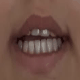

In [66]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = batch[None, j, :]

    return frame_features


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    probabilities = model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames*255


# This utility is for visualization.
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


test_video = np.random.choice(test_df["file_path"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [67]:
model.save('/content/drive/MyDrive/video_classifier_3D_CNN/HW3_3_c_11.h5')

## confusion matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


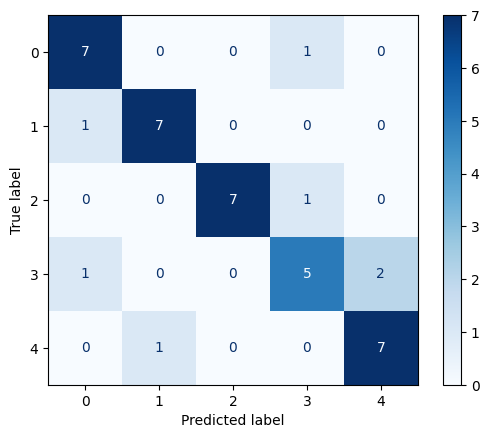

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test = test_labels
y_pred = model.predict(test_data)

labels = classes
y_pred_plot=np.argmax(y_pred, axis=1)
y_test_plot=np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_plot, y_pred_plot)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## model architecture

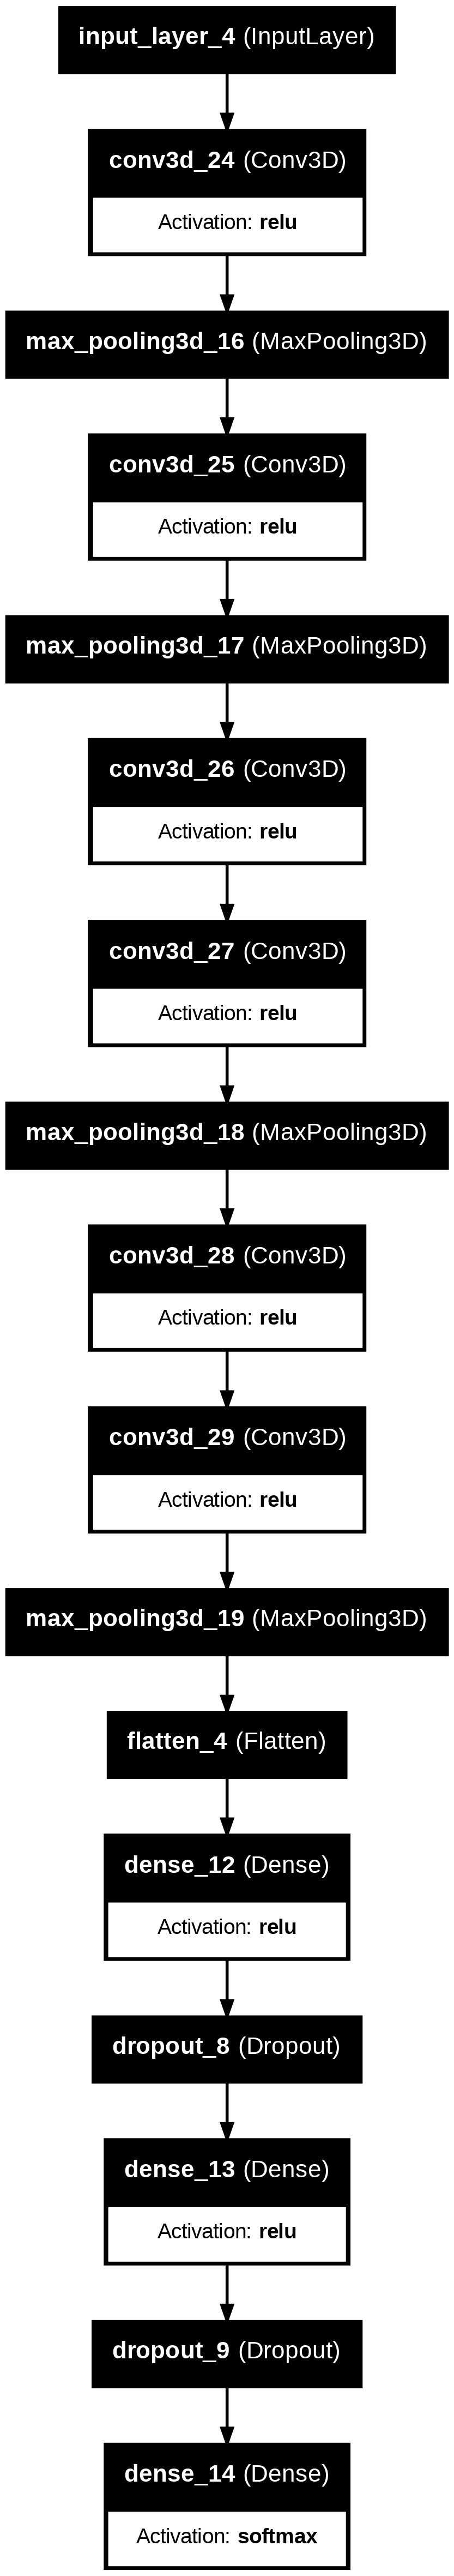

In [69]:
keras.utils.plot_model(model, show_layer_activations=True, show_layer_names=True)

# loading and evaluating the best model

model link = https://drive.google.com/file/d/1-F1z9xREjOpNoKEzzQuXSEEcTeUfZjf2/view?usp=drive_link

best model name = HW3_3_c_11.h5

In [70]:
from keras.models import load_model
my_model = load_model('/content/drive/MyDrive/video_classifier_3D_CNN/HW3_3_c_11.h5')

_, accuracy = my_model.evaluate(test_data, test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.8208 - loss: 1.5382
Test accuracy: 82.5%


# comparing

the 3D CNN model really needs a large memory and it takes a lot to train, but it also reaches to high accuracy values. so I think if we have a lot of memory and time, maybe the 3D CNN is the best approach. otherwise, the CNN_Transformer is better. but we should consider that this 3D_CNN may overfit.

# references

https://www.tensorflow.org/tutorials/load_data/video#create_frames_from_each_video_file

https://www.tensorflow.org/tutorials/video/video_classification

https://keras.io/examples/vision/video_classification/

https://keras.io/api/applications/inceptionv3/

https://medium.com/@gcagrici/video-classification-with-deep-learning-3840b20b7949

https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5

https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/video_classification.ipynb#scrollTo=trmOK6x6ipyU

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/video.ipynb

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/action_recognition_with_tf_hub.ipynb

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/video_transformers.ipynb



